# Useful Resources

- https://colab.research.google.com/github/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb

# Prepare

In [1]:
!pip install -q tqdm
!pip install -q conllu
!pip install -q seaborn
!pip install -q datasets
!pip install -q scikit-learn
!pip install -q pytorch_lightning
!pip install -q git+https://github.com/MagedSaeed/tkseem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.0 MB/s eta 

In [2]:
import re
import os
import random
import string
import shutil
from pathlib import Path
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint,Callback

import datasets
import seaborn as sns
import matplotlib.pyplot as plt


import tkseem as tk
from tqdm.auto import tqdm

In [3]:
seed = 42

In [4]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [5]:
tqdm.pandas()

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load and explore the dataset

In [7]:
train_dataset = datasets.load_dataset("conllpp",split='train')
train_dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conllpp downloaded and prepared to /root/.cache/huggingface/datasets/conllpp/conllpp/1.0.0/04f15f257dff3fe0fb36e049b73d51ecdf382698682f5e590b7fb13898206ba2. Subsequent calls will reuse this data.


Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [8]:
validation_dataset = datasets.load_dataset("conllpp",split='validation')
validation_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3250
})

In [9]:
test_dataset = datasets.load_dataset("conllpp",split='test')
test_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3453
})

Converting to Pandas and droping duplicates

In [10]:
train_dataset = train_dataset.to_pandas()
train_dataset

id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]  
1                                                 [1, 2]  
2                                                 [5, 0]  
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...  
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...  
...                                                  ...  
14036                                          [0, 0, 0]  
14037                                             [0, 0]  
14038                                       [3, 0, 3, 0]  
14039                                             [0, 0]  
14040                                       [3, 0, 3, 0]  

[14041 rows x 5 columns]

In [11]:
# train_dataset = train_dataset.drop_duplicates(subset=['tokens'],keep='first').copy()
# train_dataset

In [12]:
validation_dataset = validation_dataset.to_pandas()
validation_dataset

id                                             tokens  \
0        0  [CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...   
1        1                               [LONDON, 1996-08-30]   
2        2  [West, Indian, all-rounder, Phil, Simmons, too...   
3        3  [Their, stay, on, top, ,, though, ,, may, be, ...   
4        4  [After, bowling, Somerset, out, for, 83, on, t...   
...    ...                                                ...   
3245  3245  [But, the, prices, may, move, in, a, close, ra...   
3246  3246  [Brokers, said, blue, chips, like, IDLC, ,, Ba...   
3247  3247  [They, said, there, was, still, demand, for, b...   
3248  3248  [The, DSE, all, share, price, index, closed, 2...   
3249  3249                [--, Dhaka, Newsroom, 880-2-506363]   

                                               pos_tags  \
0            [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]   
1                                              [22, 11]   
2     [22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...   
3     [29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...   
4     [15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...   
...                                                 ...   
3245  [10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...   
3246  [24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...   
3247  [28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...   
3248  [12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...   
3249                                    [8, 22, 22, 11]   

                                             chunk_tags  \
0            [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]   
1                                              [11, 12]   
2     [11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...   
3     [11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...   
4     [13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...   
...                                                 ...   
3245  [0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...   
3246  [11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...   
3247  [11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...   
3248  [11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...   
3249                                    [0, 11, 12, 12]   

                                               ner_tags  
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]  
1                                                [5, 0]  
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...  
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...  
...                                                 ...  
3245   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...  
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3249                                       [0, 3, 4, 0]  

[3250 rows x 5 columns]

In [13]:
# validation_dataset = validation_dataset.drop_duplicates(subset=['tokens'],keep='first').copy()
# validation_dataset

In [14]:
test_dataset = test_dataset.to_pandas()
test_dataset

id                                             tokens  \
0        0  [SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...   
1        1                                     [Nadim, Ladki]   
2        2    [AL-AIN, ,, United, Arab, Emirates, 1996-12-06]   
3        3  [Japan, began, the, defence, of, their, Asian,...   
4        4  [But, China, saw, their, luck, desert, them, i...   
...    ...                                                ...   
3448  3448  [That, is, why, this, is, so, emotional, a, ni...   
3449  3449  [", It, was, the, joy, that, we, all, had, ove...   
3450  3450  [Charlton, managed, Ireland, for, 93, matches,...   
3451  3451  [He, guided, Ireland, to, two, successive, Wor...   
3452  3452  [The, lanky, former, Leeds, United, defender, ...   

                                               pos_tags  \
0         [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7]   
1                                              [22, 22]   
2                               [22, 6, 22, 22, 23, 11]   
3     [22, 38, 12, 21, 15, 29, 16, 22, 21, 15, 12, 1...   
4     [10, 22, 38, 29, 21, 37, 28, 15, 12, 21, 21, 1...   
...                                                 ...   
3448  [12, 42, 46, 12, 42, 30, 16, 12, 21, 15, 28, 6...   
3449  [0, 28, 38, 12, 21, 15, 28, 12, 38, 15, 12, 21...   
3450  [22, 38, 22, 15, 11, 24, 6, 15, 43, 21, 28, 38...   
3451  [28, 38, 22, 35, 11, 16, 22, 22, 24, 24, 10, 3...   
3452  [12, 16, 16, 22, 22, 21, 38, 30, 37, 29, 22, 2...   

                                             chunk_tags  \
0         [12, 0, 12, 22, 12, 12, 0, 12, 14, 12, 12, 0]   
1                                              [12, 12]   
2                               [12, 0, 12, 12, 12, 12]   
3     [12, 22, 12, 12, 14, 12, 12, 12, 12, 14, 12, 1...   
4     [0, 12, 22, 12, 12, 22, 12, 14, 12, 12, 12, 14...   
...                                                 ...   
3448  [12, 22, 4, 12, 22, 2, 2, 12, 12, 14, 12, 0, 0...   
3449  [0, 12, 22, 12, 12, 18, 12, 11, 22, 14, 12, 12...   
3450  [12, 22, 12, 14, 12, 12, 0, 14, 12, 12, 11, 22...   
3451  [12, 22, 12, 22, 12, 12, 12, 12, 12, 12, 0, 14...   
3452  [12, 12, 12, 12, 12, 12, 22, 22, 22, 12, 12, 1...   

                                               ner_tags  
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]  
1                                                [1, 2]  
2                                    [5, 0, 5, 6, 6, 0]  
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
3448   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...  
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...  

[3453 rows x 5 columns]

In [15]:
# test_dataset = test_dataset.drop_duplicates(subset=['tokens'],keep='first').copy()
# test_dataset

In [16]:
test_dataset['tokens'][4],test_dataset['ner_tags'][4]

(array(['But', 'China', 'saw', 'their', 'luck', 'desert', 'them', 'in',
        'the', 'second', 'match', 'of', 'the', 'group', ',', 'crashing',
        'to', 'a', 'surprise', '2-0', 'defeat', 'to', 'newcomers',
        'Uzbekistan', '.'], dtype=object),
 array([0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 5, 0]))

delete the tokens class 13 as it is placeholder for connected words "as far as I understand from the above example"

In [17]:
number_of_tags = len(set([tag for tags in train_dataset['ner_tags'] for tag in tags]))
number_of_tags

9

Count positives and negatives

<BarContainer object of 9 artists>

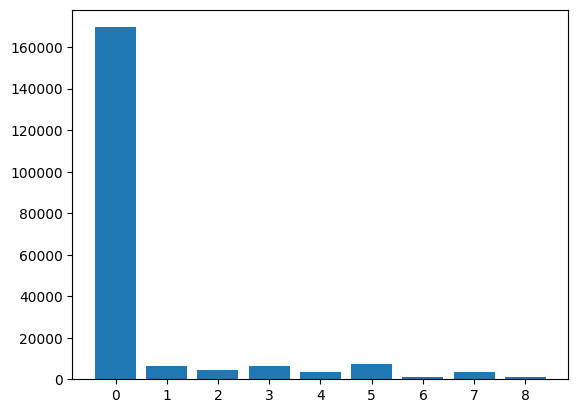

In [18]:
# Create a count plot
tags = [tag for sample in train_dataset['ner_tags'] for tag in sample]
tags_counter = Counter(tags)
plt.xticks(range(number_of_tags))
plt.bar(tags_counter.keys(),tags_counter.values())

In [19]:
tags_counter.most_common()

[(0, 169578),
 (5, 7140),
 (1, 6600),
 (3, 6321),
 (2, 4528),
 (4, 3704),
 (7, 3438),
 (6, 1157),
 (8, 1155)]

In [20]:
sum(tags_counter.values())

203621

testset and trainset vocabulary and tokens count:


In [21]:
vocabs_dict = {}
for tokens_list in test_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('9,488', '46,435')

In [22]:
vocabs_dict = {}
for tokens_list in validation_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('9,966', '51,362')

In [23]:
vocabs_dict = {}
for tokens_list in train_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('23,623', '203,621')

# create helper functions and set constants

In [24]:
max(map(len,train_dataset['tokens'])),max(map(len,test_dataset['tokens']))

(113, 124)

In [25]:
# setting seq_len:
seq_len = 130
pad_tag = number_of_tags # tags starts from zero :)

In [26]:
def create_features_from_tokens_list(tokens_list,tags_list,tokenizer):
  encoded = list()
  padded_tags = list()
  for tokens,tags in tqdm(zip(tokens_list,tags_list)):
    text = ' '.join(tokens)
    encoded_doc = tokenizer.encode(text)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
    padded_tags.append(np.pad(
        tags,
        pad_width=(0,seq_len-len(tags)),
        constant_values=pad_tag,
      )
    )
  return np.array(encoded),np.array(padded_tags).astype(int)

In [27]:
# define batch size
batch_size = 256

In [28]:
def mask_vowels(tokens_list, mask=""):
  masked_tokens_list = list()
  for token in tokens_list:
    masked_token = re.sub(
      r"[AEIOU]",
      mask,
      token,
      flags=re.IGNORECASE,
    )
    if masked_token:
      masked_tokens_list.append(masked_token)
  return masked_tokens_list

# Build the BiLSTM Model

## The Model Architecture

In [29]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitBiLSTMModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        pad_id=1, # the default value from tkseem tokenizers
        pad_tag=pad_tag,
        seq_len=seq_len,
        output_size=10, # one class is added for padding
        hidden_size=256,
        embedding_size=512,
        embedding_dropout=0.5,
        dropout=0.5,
        learning_rate=0.001,
        n_layers=4,
        bidirectional=True,
      ):
        super().__init__()

        self.save_hyperparameters()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout
        self.pad_tag = pad_tag
        self.pad_id = pad_id
        self.max_sequence_length = seq_len
        self.output_size = output_size

        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        outputs = self.embedding(inputs)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        inputs_lengths = torch.sum(inputs!=self.pad_id,axis=-1).cpu()
        packed_outputs = nn.utils.rnn.pack_padded_sequence(
            outputs,
            inputs_lengths,
            batch_first=True,
            enforce_sorted=False,
          )
        if not self.bidirectional:
          # pass forward to lstm
          packed_outputs, _ =  self.lstm(packed_outputs)
          outputs,lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        else:
          bidirectional_packed_outputs,_ = self.lstm(packed_outputs)
          bidirectional_outputs,lengths = nn.utils.rnn.pad_packed_sequence(
              bidirectional_packed_outputs,
              batch_first=True,
              # padding_value=self.pad_id,
              total_length=self.max_sequence_length,
            )
          outputs = bidirectional_outputs[:, :, : self.hidden_size] + bidirectional_outputs[:, :, self.hidden_size :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # softmax will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        assert torch.sum(inputs==self.pad_id)==torch.sum(labels==self.pad_tag),\
             f'pad ids and their target tags does not match: {torch.sum(inputs==self.pad_id):=} != {torch.sum(labels==self.pad_tag):=}'
        outputs = self(inputs)
        outputs = outputs.squeeze()
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1],-1)
        labels = labels.view(-1)
        return outputs,labels

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        test_accuracy = self.test_accuracy(outputs,labels)
        metrics = {"test_acc": test_accuracy, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=1,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

## util classes/functions

In [30]:
class ConfusionMatrixCallback(Callback):
  def __init__(self,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.predictions = list()
    self.labels = list()

  def on_test_batch_end(self,trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
    super().on_test_batch_end(
        trainer,
        pl_module,
        outputs,
        batch,
        batch_idx,
        dataloader_idx,
      )
    inputs,labels = batch
    outputs = outputs.view(inputs.shape[0]*inputs.shape[1],-1)
    batch_predictions = torch.argmax(outputs,dim=-1)
    self.predictions.append(batch_predictions)
    labels = labels.view(-1)
    self.labels.append(labels)

  def on_test_end(self, trainer, pl_module) -> None:
     super().on_test_end(trainer, pl_module)
     predictions = torch.cat(self.predictions).cpu()
     labels = torch.cat(self.labels).cpu()
     confusion_matrix_calculator = torchmetrics.ConfusionMatrix(
            task="multiclass",
            num_classes=trainer.model.output_size,
            ignore_index=trainer.model.pad_tag,
     )
     confusion_matrix = confusion_matrix_calculator(predictions,labels)
     # zero out lists for future calculations
     self.predictions = list()
     self.labels = list()
     plt.figure(figsize = (10,7))
     sns.heatmap(confusion_matrix, annot=True,linewidths=0.5,fmt='g',cmap='Blues')

In [31]:
def get_best_checkpoint(text_type,checkpoints_base_path="./NERTagging"):
    checkpoints_path = (
        f"{checkpoints_base_path}/{text_type}/checkpoints"
    )
    for file_name in os.listdir(checkpoints_path):
        if file_name.startswith("epoch"):
            return f"{checkpoints_path}/{file_name}"

In [32]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
  ):
  checkpoints_path = Path(f"./NERTagging/{text_type}")
  shutil.rmtree(checkpoints_path, ignore_errors=True)
  checkpoint_callback = ModelCheckpoint(
      mode="min",
      save_top_k=1,
      verbose=False,
      save_last=True,
      monitor="val_loss",
      save_weights_only=False,
      auto_insert_metric_name=True,
      save_on_train_epoch_end=False,
      dirpath=f"{checkpoints_path}/checkpoints",
      filename="{epoch}-{val_loss:.3f}-{step}",
  )
  callbacks = list()
  callbacks.append(checkpoint_callback)
  confusion_matrix_callback = ConfusionMatrixCallback()
  callbacks.append(confusion_matrix_callback)
  early_stopping_callback = EarlyStopping(
      monitor="val_loss",
      # min_delta=0.025,
      min_delta=0,
      patience=10,
      check_finite=True,
  )
  callbacks.append(early_stopping_callback)
  lr_monitor = LearningRateMonitor(
      logging_interval="step",
      log_momentum=True,
  )
  callbacks.append(lr_monitor)
  devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainer = Trainer(
      deterministic=True,
      callbacks=callbacks,
      gradient_clip_val=5,
      fast_dev_run=False,
      max_epochs=max_epochs,
      val_check_interval=0.5,
      accelerator="auto",
      # log_every_n_steps=max(len(train_dataloader) // 25, 1),
      log_every_n_steps=max(len(train_dataloader) // 25, 1),
  )
  trainer.validate(
      model=model,
      dataloaders=val_dataloader,
  )
  trainer.fit(
      model,
      train_dataloader,
      val_dataloader,
  )
  return trainer

# Normal English

## Prepare the tokenizer

In [33]:
tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [34]:
tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['tokens']))

Training WordTokenizer ...


In [35]:
tokenizer.vocab_size

23625

In [36]:
# test the tokenizer
tokenizer.tokenize('the hello world , fractionally')

['the', '<UNK>', 'world', ',', 'fractionally']

## tokenize and split

In [37]:
encoded_trainset,trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['tokens'],
    tags_list=train_dataset['ner_tags'],
    tokenizer=tokenizer,
  )
encoded_valset,valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['tokens'],
    tags_list=validation_dataset['ner_tags'],
    tokenizer=tokenizer,
  )
encoded_testset,testy = create_features_from_tokens_list(
    tokens_list=test_dataset['tokens'],
    tags_list=test_dataset['ner_tags'],
    tokenizer=tokenizer,
  )
encoded_trainset.shape,trainy.shape,encoded_valset.shape,valy.shape,encoded_testset.shape,testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((14041, 130),
 (14041, 130),
 (3250, 130),
 (3250, 130),
 (3453, 130),
 (3453, 130))

In [38]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))

In [39]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [40]:
model = LitBiLSTMModel(vocab_size=tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(23625, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [41]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='all-characters',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.279728412628174     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 12.1 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 2.6 K 
---------------------------------------------------------
18.4 M    Trainable params
0         Non-trainable params
18.4 M    Total params
73.626    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 6.2500e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 3.1250e-05.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.939744770526886     │
│         test_loss         │    0.23589450120925903    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.939744770526886, 'test_loss': 0.23589450120925903}]

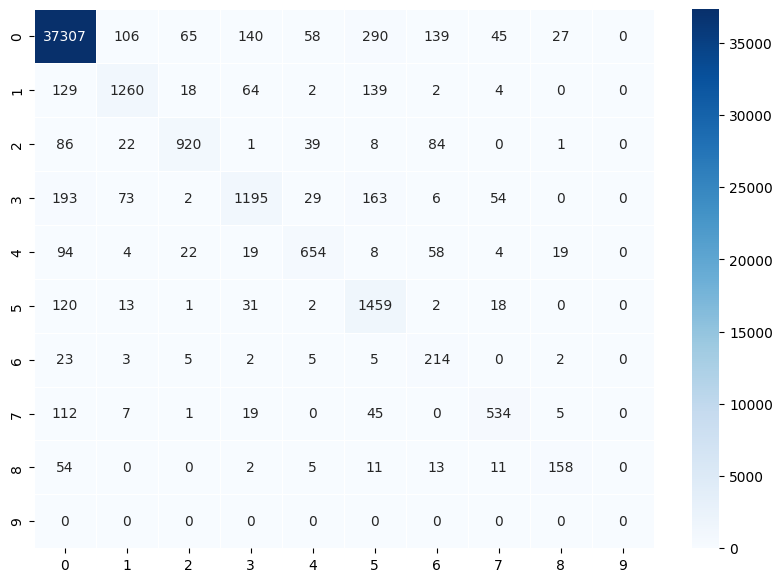

In [42]:
#9119 test on the last model
trainer.test(model,testloader)

In [43]:
# test on teh best model according to val accuracy
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters',),
    vocab_size=tokenizer.vocab_size
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(23625, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.942883312702179     │
│         test_loss         │    0.22674161195755005    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.942883312702179, 'test_loss': 0.22674161195755005}]

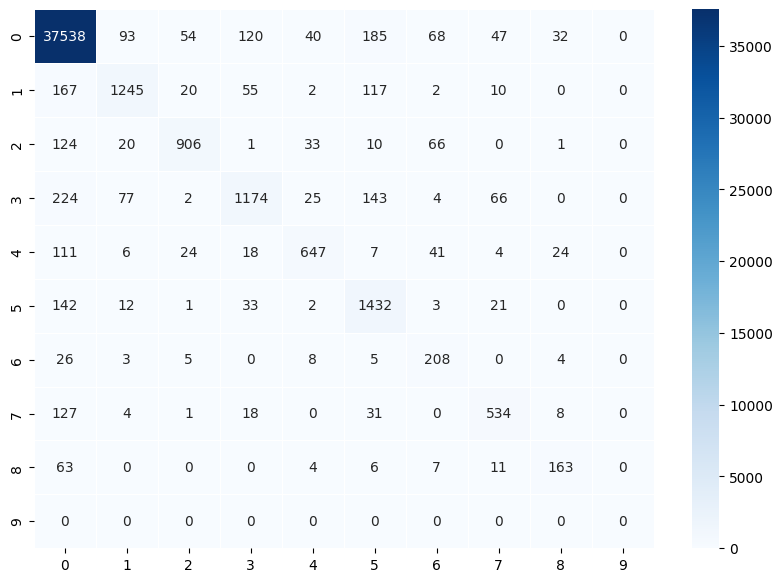

In [44]:
trainer.test(model,testloader)

# Consonants only

## prepare the dataset

In [45]:
# go over tokens, if a token contains only vowels, drop its upos tag
train_dataset['constants_ners'] = train_dataset.progress_apply(lambda row: [tag for tag,token in zip(row['ner_tags'],row['tokens']) if not set(token).issubset('AaEeIiOoUu')],axis=1)
train_dataset

  0%|          | 0/14041 [00:00<?, ?it/s]

id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  \
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                          constants_ners  
0                               [0, 7, 0, 0, 0, 7, 0, 0]  
1                                                 [1, 2]  
2                                                 [5, 0]  
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...  
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...  
...                                                  ...  
14036                                          [0, 0, 0]  
14037                                             [0, 0]  
14038                                       [3, 0, 3, 0]  
14039                                             [0, 0]  
14040                                       [3, 0, 3, 0]  

[14041 rows x 6 columns]

In [46]:
train_dataset['constants_tokens'] = list(train_dataset['tokens'].progress_apply(mask_vowels))
train_dataset

  0%|          | 0/14041 [00:00<?, ?it/s]

id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  \
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                          constants_ners  \
0                               [0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                        constants_tokens  
0            [rjcts, Grmn, cll, t, byctt, Brtsh, lmb, .]  
1                                         [Ptr, Blckbrn]  
2                                   [BRSSLS, 1996-08-22]  
3      [Th, rpn, Cmmssn, sd, n, Thrsdy, t, dsgrd, wth...  
4      [Grmny, 's, rprsntt

some elemnts may become empty, let us count how many:

In [47]:
c = 0
for t in train_dataset['constants_tokens']:
  if len(t) == 0:
    c+=1
print('number of rows becomong empty:',c)

number of rows becomong empty: 1


dropping them

In [48]:
train_dataset = train_dataset[train_dataset['constants_tokens'].map(lambda row: len(row)) > 0]
train_dataset

id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  \
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                          constants_ners  \
0                               [0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                        constants_tokens  
0            [rjcts, Grmn, cll, t, byctt, Brtsh, lmb, .]  
1                                         [Ptr, Blckbrn]  
2                                   [BRSSLS, 1996-08-22]  
3      [Th, rpn, Cmmssn, sd, n, Thrsdy, t, dsgrd, wth...  
4      [Grmny, 's, rprsntt

In [49]:
# let us find out the tokens that are all vowels to analyze the severity of their removal
vowel_words = list()
vowel_tags = list()
for index,row in tqdm(train_dataset.iterrows()):
  for index,token in enumerate(row['tokens']):
    if set(token).issubset('AaEeIiOoUu'):
      vowel_words.append(token)
      vowel_tags.append(row['ner_tags'][index])
set(vowel_words),len(vowel_words),len(set(vowel_words)),Counter(vowel_words).most_common(),\
set(vowel_tags),len(vowel_tags),len(set(vowel_tags)),Counter(vowel_tags).most_common()

0it [00:00, ?it/s]

({'A',
  'AA',
  'AEI',
  'Aa',
  'Ai',
  'E',
  'EOE',
  'EU',
  'Eau',
  'I',
  'IA',
  'II',
  'III',
  'O',
  'U',
  'UAE',
  'a',
  'i',
  'o'},
 3569,
 19,
 [('a', 2994),
  ('I', 307),
  ('A', 205),
  ('EU', 24),
  ('II', 11),
  ('UAE', 5),
  ('Ai', 4),
  ('O', 4),
  ('E', 2),
  ('Eau', 2),
  ('III', 2),
  ('AEI', 2),
  ('o', 1),
  ('i', 1),
  ('AA', 1),
  ('Aa', 1),
  ('EOE', 1),
  ('U', 1),
  ('IA', 1)],
 {0, 1, 2, 3, 4, 5, 7, 8},
 3569,
 8,
 [(0, 3505), (3, 33), (4, 9), (8, 8), (5, 6), (2, 4), (1, 3), (7, 1)])

In [50]:
# assert that constants ners and constants tokens have the same length always
for index,row in train_dataset.iterrows():
  if len(row['constants_ners']) != len(row['constants_tokens']):
    print(row['constants_ners'],'and',row['contants_tokens'],'does not have the same length!')
    break
else:
  print('all contants ners and constant tokens rows have the same length')

all contants ners and constant tokens rows have the same length


In [51]:
train_dataset['constants_tokens'][0],train_dataset['tokens'][0]

(['rjcts', 'Grmn', 'cll', 't', 'byctt', 'Brtsh', 'lmb', '.'],
 array(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British',
        'lamb', '.'], dtype=object))

apply similar processing for validation set

In [52]:
validation_dataset['constants_ners'] = validation_dataset.progress_apply(lambda row: [tag for tag,token in zip(row['ner_tags'],row['tokens']) if not set(token).issubset('AaEeIiOoUu')],axis=1)
validation_dataset

  0%|          | 0/3250 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...   
1        1                               [LONDON, 1996-08-30]   
2        2  [West, Indian, all-rounder, Phil, Simmons, too...   
3        3  [Their, stay, on, top, ,, though, ,, may, be, ...   
4        4  [After, bowling, Somerset, out, for, 83, on, t...   
...    ...                                                ...   
3245  3245  [But, the, prices, may, move, in, a, close, ra...   
3246  3246  [Brokers, said, blue, chips, like, IDLC, ,, Ba...   
3247  3247  [They, said, there, was, still, demand, for, b...   
3248  3248  [The, DSE, all, share, price, index, closed, 2...   
3249  3249                [--, Dhaka, Newsroom, 880-2-506363]   

                                               pos_tags  \
0            [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]   
1                                              [22, 11]   
2     [22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...   
3     [29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...   
4     [15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...   
...                                                 ...   
3245  [10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...   
3246  [24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...   
3247  [28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...   
3248  [12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...   
3249                                    [8, 22, 22, 11]   

                                             chunk_tags  \
0            [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]   
1                                              [11, 12]   
2     [11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...   
3     [11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...   
4     [13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...   
...                                                 ...   
3245  [0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...   
3246  [11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...   
3247  [11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...   
3248  [11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...   
3249                                    [0, 11, 12, 12]   

                                               ner_tags  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                         constants_ners  
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]  
1                                                [5, 0]  
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...  
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...  
...                                                 ...  
3245         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...  
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3249                                       [0, 3, 4, 0]  

[3250 rows x 6 columns]

In [53]:
validation_dataset['constants_tokens'] = list(validation_dataset['tokens'].progress_apply(mask_vowels))
validation_dataset

  0%|          | 0/3250 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...   
1        1                               [LONDON, 1996-08-30]   
2        2  [West, Indian, all-rounder, Phil, Simmons, too...   
3        3  [Their, stay, on, top, ,, though, ,, may, be, ...   
4        4  [After, bowling, Somerset, out, for, 83, on, t...   
...    ...                                                ...   
3245  3245  [But, the, prices, may, move, in, a, close, ra...   
3246  3246  [Brokers, said, blue, chips, like, IDLC, ,, Ba...   
3247  3247  [They, said, there, was, still, demand, for, b...   
3248  3248  [The, DSE, all, share, price, index, closed, 2...   
3249  3249                [--, Dhaka, Newsroom, 880-2-506363]   

                                               pos_tags  \
0            [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]   
1                                              [22, 11]   
2     [22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...   
3     [29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...   
4     [15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...   
...                                                 ...   
3245  [10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...   
3246  [24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...   
3247  [28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...   
3248  [12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...   
3249                                    [8, 22, 22, 11]   

                                             chunk_tags  \
0            [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]   
1                                              [11, 12]   
2     [11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...   
3     [11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...   
4     [13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...   
...                                                 ...   
3245  [0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...   
3246  [11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...   
3247  [11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...   
3248  [11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...   
3249                                    [0, 11, 12, 12]   

                                               ner_tags  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                         constants_ners  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                       constants_tokens  
0     [CRCKT, -, LCSTRSHR, TK, VR, T, TP, FTR, NNNGS...  
1                                    [LNDN, 1996-08-30]  
2     [Wst, ndn, ll-rndr, Phl, Smmns, tk, fr, fr, 38...  
3     [Thr, sty, n, tp, ,, thgh, ,, my, b, shrt-lvd,...  
4     [ftr, bwlng, Smrst, t, fr, 83, n, th, pnng, mr...  
...                                        

In [54]:
c = 0
for t in validation_dataset['constants_tokens']:
  if len(t) == 0:
    c+=1
print('number of rows becomong empty:',c)

number of rows becomong empty: 0


In [55]:
# assert that constants upos and constants tokens have the same length always
for index,row in validation_dataset.iterrows():
  if len(row['constants_ners']) != len(row['constants_tokens']):
    print(row['constants_ners'],'and',row['contants_tokens'],'does not have the same length!')
    break
else:
  print('all contants ners and constant tokens rows have the same length')

all contants ners and constant tokens rows have the same length


apply similar processing for test set

In [56]:
# go over tokens, if a token contains only vowels, drop its upos tag
test_dataset['constants_ners'] = test_dataset.progress_apply(lambda row: [tag for tag,token in zip(row['ner_tags'],row['tokens']) if not set(token).issubset('AaEeIiOoUu')],axis=1)
test_dataset

  0%|          | 0/3453 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...   
1        1                                     [Nadim, Ladki]   
2        2    [AL-AIN, ,, United, Arab, Emirates, 1996-12-06]   
3        3  [Japan, began, the, defence, of, their, Asian,...   
4        4  [But, China, saw, their, luck, desert, them, i...   
...    ...                                                ...   
3448  3448  [That, is, why, this, is, so, emotional, a, ni...   
3449  3449  [", It, was, the, joy, that, we, all, had, ove...   
3450  3450  [Charlton, managed, Ireland, for, 93, matches,...   
3451  3451  [He, guided, Ireland, to, two, successive, Wor...   
3452  3452  [The, lanky, former, Leeds, United, defender, ...   

                                               pos_tags  \
0         [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7]   
1                                              [22, 22]   
2                               [22, 6, 22, 22, 23, 11]   
3     [22, 38, 12, 21, 15, 29, 16, 22, 21, 15, 12, 1...   
4     [10, 22, 38, 29, 21, 37, 28, 15, 12, 21, 21, 1...   
...                                                 ...   
3448  [12, 42, 46, 12, 42, 30, 16, 12, 21, 15, 28, 6...   
3449  [0, 28, 38, 12, 21, 15, 28, 12, 38, 15, 12, 21...   
3450  [22, 38, 22, 15, 11, 24, 6, 15, 43, 21, 28, 38...   
3451  [28, 38, 22, 35, 11, 16, 22, 22, 24, 24, 10, 3...   
3452  [12, 16, 16, 22, 22, 21, 38, 30, 37, 29, 22, 2...   

                                             chunk_tags  \
0         [12, 0, 12, 22, 12, 12, 0, 12, 14, 12, 12, 0]   
1                                              [12, 12]   
2                               [12, 0, 12, 12, 12, 12]   
3     [12, 22, 12, 12, 14, 12, 12, 12, 12, 14, 12, 1...   
4     [0, 12, 22, 12, 12, 22, 12, 14, 12, 12, 12, 14...   
...                                                 ...   
3448  [12, 22, 4, 12, 22, 2, 2, 12, 12, 14, 12, 0, 0...   
3449  [0, 12, 22, 12, 12, 18, 12, 11, 22, 14, 12, 12...   
3450  [12, 22, 12, 14, 12, 12, 0, 14, 12, 12, 11, 22...   
3451  [12, 22, 12, 22, 12, 12, 12, 12, 12, 12, 0, 14...   
3452  [12, 12, 12, 12, 12, 12, 22, 22, 22, 12, 12, 1...   

                                               ner_tags  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                         constants_ners  
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]  
1                                                [1, 2]  
2                                    [5, 0, 5, 6, 6, 0]  
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 5, ...  
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
3448      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...  
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...  

[3453 rows x 6 columns]

In [57]:
test_dataset['constants_tokens'] = list(test_dataset['tokens'].progress_apply(mask_vowels))
test_dataset

  0%|          | 0/3453 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...   
1        1                                     [Nadim, Ladki]   
2        2    [AL-AIN, ,, United, Arab, Emirates, 1996-12-06]   
3        3  [Japan, began, the, defence, of, their, Asian,...   
4        4  [But, China, saw, their, luck, desert, them, i...   
...    ...                                                ...   
3448  3448  [That, is, why, this, is, so, emotional, a, ni...   
3449  3449  [", It, was, the, joy, that, we, all, had, ove...   
3450  3450  [Charlton, managed, Ireland, for, 93, matches,...   
3451  3451  [He, guided, Ireland, to, two, successive, Wor...   
3452  3452  [The, lanky, former, Leeds, United, defender, ...   

                                               pos_tags  \
0         [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7]   
1                                              [22, 22]   
2                               [22, 6, 22, 22, 23, 11]   
3     [22, 38, 12, 21, 15, 29, 16, 22, 21, 15, 12, 1...   
4     [10, 22, 38, 29, 21, 37, 28, 15, 12, 21, 21, 1...   
...                                                 ...   
3448  [12, 42, 46, 12, 42, 30, 16, 12, 21, 15, 28, 6...   
3449  [0, 28, 38, 12, 21, 15, 28, 12, 38, 15, 12, 21...   
3450  [22, 38, 22, 15, 11, 24, 6, 15, 43, 21, 28, 38...   
3451  [28, 38, 22, 35, 11, 16, 22, 22, 24, 24, 10, 3...   
3452  [12, 16, 16, 22, 22, 21, 38, 30, 37, 29, 22, 2...   

                                             chunk_tags  \
0         [12, 0, 12, 22, 12, 12, 0, 12, 14, 12, 12, 0]   
1                                              [12, 12]   
2                               [12, 0, 12, 12, 12, 12]   
3     [12, 22, 12, 12, 14, 12, 12, 12, 12, 14, 12, 1...   
4     [0, 12, 22, 12, 12, 22, 12, 14, 12, 12, 12, 14...   
...                                                 ...   
3448  [12, 22, 4, 12, 22, 2, 2, 12, 12, 14, 12, 0, 0...   
3449  [0, 12, 22, 12, 12, 18, 12, 11, 22, 14, 12, 12...   
3450  [12, 22, 12, 14, 12, 12, 0, 14, 12, 12, 11, 22...   
3451  [12, 22, 12, 22, 12, 12, 12, 12, 12, 12, 0, 14...   
3452  [12, 12, 12, 12, 12, 12, 22, 22, 22, 12, 12, 1...   

                                               ner_tags  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                         constants_ners  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 5, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                       constants_tokens  
0     [SCCR, -, JPN, GT, LCKY, WN, ,, CHN, N, SRPRS,...  
1                                            [Ndm, Ldk]  
2                   [L-N, ,, ntd, rb, mrts, 1996-12-06]  
3     [Jpn, bgn, th, dfnc, f, thr, sn, Cp, ttl, wth,...  
4     [Bt, Chn, sw, thr, lck, dsrt, thm, n, th, scnd...  
...                                        

In [58]:
c = 0
for t in test_dataset['constants_tokens']:
  if len(t) == 0:
    c+=1
print('number of rows becomong empty:',c)

number of rows becomong empty: 0


In [59]:
# assert that constants upos and constants tokens have the same length always
for index,row in test_dataset.iterrows():
  if len(row['constants_ners']) != len(row['constants_tokens']):
    print(row['constants_ners'],'and',row['contants_tokens'],'does not have the same length!')
    break
else:
  print('all contants ners and constant tokens rows have the same length')

all contants ners and constant tokens rows have the same length


In [60]:
test_dataset['constants_tokens'][0],test_dataset['tokens'][0]

(['SCCR',
  '-',
  'JPN',
  'GT',
  'LCKY',
  'WN',
  ',',
  'CHN',
  'N',
  'SRPRS',
  'DFT',
  '.'],
 array(['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN',
        'SURPRISE', 'DEFEAT', '.'], dtype=object))

## create the tokenizer

In [61]:
consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [62]:
consonants_tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['constants_tokens']))

Training WordTokenizer ...


In [63]:
consonants_tokenizer.vocab_size

19785

In [64]:
# test the tokenizer
consonants_tokenizer.tokenize('th hll wrld , frctnlly')

['th', 'hll', 'wrld', ',', 'frctnlly']

## tokenize and split

In [65]:
consonants_encoded_trainset,consonants_trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['constants_tokens'],
    tags_list=train_dataset['constants_ners'],
    tokenizer=consonants_tokenizer,
  )
consonants_encoded_valset,consonants_valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['constants_tokens'],
    tags_list=validation_dataset['constants_ners'],
    tokenizer=consonants_tokenizer,
  )
consonants_encoded_testset,consonants_testy = create_features_from_tokens_list(
    tokens_list=test_dataset['constants_tokens'],
    tags_list=test_dataset['constants_ners'],
    tokenizer=consonants_tokenizer,
  )
consonants_encoded_trainset.shape,consonants_trainy.shape,consonants_encoded_valset.shape,consonants_valy.shape,consonants_encoded_testset.shape,consonants_testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((14040, 130),
 (14040, 130),
 (3250, 130),
 (3250, 130),
 (3453, 130),
 (3453, 130))

In [66]:
# create tensor datasets
consonants_trainset = TensorDataset(torch.from_numpy(consonants_encoded_trainset), torch.from_numpy(consonants_trainy))
consonants_validset = TensorDataset(torch.from_numpy(consonants_encoded_valset), torch.from_numpy(consonants_valy))
consonants_testset = TensorDataset(torch.from_numpy(consonants_encoded_testset), torch.from_numpy(consonants_testy))

In [67]:
consonants_trainy

array([[0, 7, 0, ..., 9, 9, 9],
       [1, 2, 9, ..., 9, 9, 9],
       [5, 0, 9, ..., 9, 9, 9],
       ...,
       [3, 0, 3, ..., 9, 9, 9],
       [0, 0, 9, ..., 9, 9, 9],
       [3, 0, 3, ..., 9, 9, 9]])

In [68]:
# create dataloaders
consonants_trainloader = DataLoader(consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
consonants_valloader = DataLoader(consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
consonants_testloader = DataLoader(consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [69]:
model = LitBiLSTMModel(vocab_size=consonants_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(19785, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [70]:
trainer = train_model(
    model,
    train_dataloader=consonants_trainloader,
    val_dataloader=consonants_valloader,
    text_type='consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.2895593643188477     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 10.1 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 2.6 K 
---------------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.761    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.938847541809082     │
│         test_loss         │    0.26142317056655884    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.938847541809082, 'test_loss': 0.26142317056655884}]

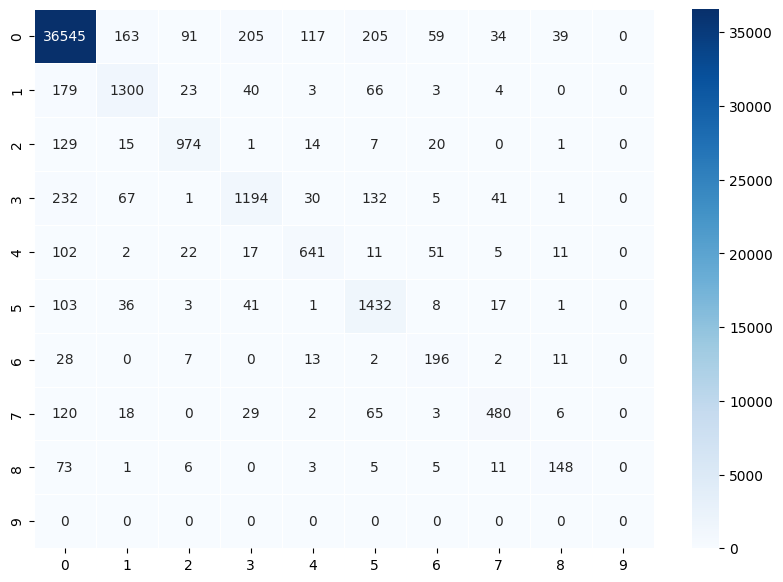

In [71]:
# test on the last model
trainer.test(model,consonants_testloader)

In [72]:
# test on the best model according to the val loss
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='consonants',),
    vocab_size=consonants_tokenizer.vocab_size,
  )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(19785, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9362205266952515     │
│         test_loss         │    0.25280389189720154    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9362205266952515, 'test_loss': 0.25280389189720154}]

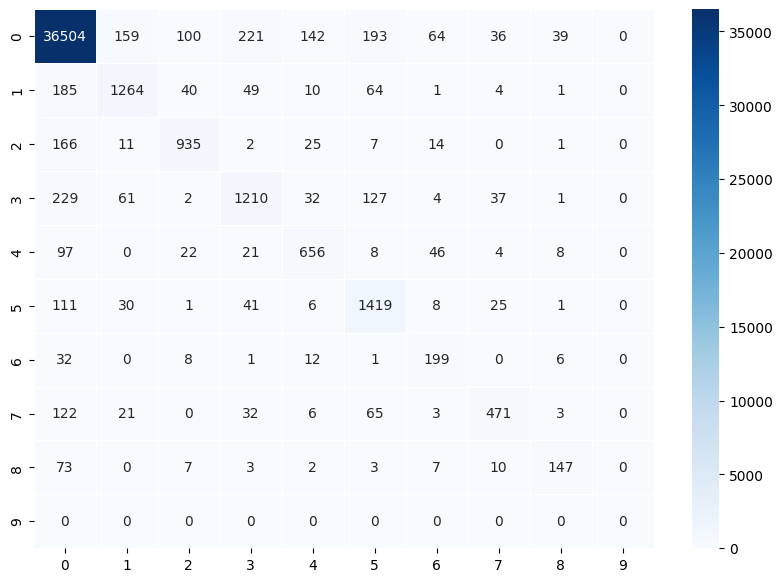

In [73]:
trainer.test(model,consonants_testloader)

# Masked Consonants

## prepare the dataset

In [74]:
train_dataset['masked_constants_tokens'] = list(train_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a")))
train_dataset

  0%|          | 0/14040 [00:00<?, ?it/s]

<ipython-input-74-13997218a22e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['masked_constants_tokens'] = list(train_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a")))


id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  \
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                          constants_ners  \
0                               [0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                        constants_tokens  \
0            [rjcts, Grmn, cll, t, byctt, Brtsh, lmb, .]   
1                                         [Ptr, Blckbrn]   
2                                   [BRSSLS, 1996-08-22]   
3      [Th, rpn, Cmmssn, sd, n, Thrsdy, t, dsgrd, wth...   
4      [Grmny, 's, rp

In [75]:
train_dataset['masked_constants_tokens'][0],train_dataset['tokens'][0]

(['aa', 'rajacts', 'Garman', 'call', 'ta', 'baycatt', 'Bratash', 'lamb', '.'],
 array(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British',
        'lamb', '.'], dtype=object))

In [76]:
validation_dataset['masked_constants_tokens'] = validation_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
validation_dataset

  0%|          | 0/3250 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...   
1        1                               [LONDON, 1996-08-30]   
2        2  [West, Indian, all-rounder, Phil, Simmons, too...   
3        3  [Their, stay, on, top, ,, though, ,, may, be, ...   
4        4  [After, bowling, Somerset, out, for, 83, on, t...   
...    ...                                                ...   
3245  3245  [But, the, prices, may, move, in, a, close, ra...   
3246  3246  [Brokers, said, blue, chips, like, IDLC, ,, Ba...   
3247  3247  [They, said, there, was, still, demand, for, b...   
3248  3248  [The, DSE, all, share, price, index, closed, 2...   
3249  3249                [--, Dhaka, Newsroom, 880-2-506363]   

                                               pos_tags  \
0            [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]   
1                                              [22, 11]   
2     [22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...   
3     [29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...   
4     [15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...   
...                                                 ...   
3245  [10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...   
3246  [24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...   
3247  [28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...   
3248  [12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...   
3249                                    [8, 22, 22, 11]   

                                             chunk_tags  \
0            [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]   
1                                              [11, 12]   
2     [11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...   
3     [11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...   
4     [13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...   
...                                                 ...   
3245  [0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...   
3246  [11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...   
3247  [11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...   
3248  [11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...   
3249                                    [0, 11, 12, 12]   

                                               ner_tags  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                         constants_ners  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                       constants_tokens  \
0     [CRCKT, -, LCSTRSHR, TK, VR, T, TP, FTR, NNNGS...   
1                                    [LNDN, 1996-08-30]   
2     [Wst, ndn, ll-rndr, Phl, Smmns, tk, fr, fr, 38...   
3     [Thr, sty, n, tp, ,, thgh, ,, my, b, shrt-lvd,...   
4     [ftr, bwlng, Smrst, t, fr, 83, n, th, pnng, mr...   
...                                  

In [77]:
test_dataset['masked_constants_tokens'] = test_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
test_dataset

  0%|          | 0/3453 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...   
1        1                                     [Nadim, Ladki]   
2        2    [AL-AIN, ,, United, Arab, Emirates, 1996-12-06]   
3        3  [Japan, began, the, defence, of, their, Asian,...   
4        4  [But, China, saw, their, luck, desert, them, i...   
...    ...                                                ...   
3448  3448  [That, is, why, this, is, so, emotional, a, ni...   
3449  3449  [", It, was, the, joy, that, we, all, had, ove...   
3450  3450  [Charlton, managed, Ireland, for, 93, matches,...   
3451  3451  [He, guided, Ireland, to, two, successive, Wor...   
3452  3452  [The, lanky, former, Leeds, United, defender, ...   

                                               pos_tags  \
0         [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7]   
1                                              [22, 22]   
2                               [22, 6, 22, 22, 23, 11]   
3     [22, 38, 12, 21, 15, 29, 16, 22, 21, 15, 12, 1...   
4     [10, 22, 38, 29, 21, 37, 28, 15, 12, 21, 21, 1...   
...                                                 ...   
3448  [12, 42, 46, 12, 42, 30, 16, 12, 21, 15, 28, 6...   
3449  [0, 28, 38, 12, 21, 15, 28, 12, 38, 15, 12, 21...   
3450  [22, 38, 22, 15, 11, 24, 6, 15, 43, 21, 28, 38...   
3451  [28, 38, 22, 35, 11, 16, 22, 22, 24, 24, 10, 3...   
3452  [12, 16, 16, 22, 22, 21, 38, 30, 37, 29, 22, 2...   

                                             chunk_tags  \
0         [12, 0, 12, 22, 12, 12, 0, 12, 14, 12, 12, 0]   
1                                              [12, 12]   
2                               [12, 0, 12, 12, 12, 12]   
3     [12, 22, 12, 12, 14, 12, 12, 12, 12, 14, 12, 1...   
4     [0, 12, 22, 12, 12, 22, 12, 14, 12, 12, 12, 14...   
...                                                 ...   
3448  [12, 22, 4, 12, 22, 2, 2, 12, 12, 14, 12, 0, 0...   
3449  [0, 12, 22, 12, 12, 18, 12, 11, 22, 14, 12, 12...   
3450  [12, 22, 12, 14, 12, 12, 0, 14, 12, 12, 11, 22...   
3451  [12, 22, 12, 22, 12, 12, 12, 12, 12, 12, 0, 14...   
3452  [12, 12, 12, 12, 12, 12, 22, 22, 22, 12, 12, 1...   

                                               ner_tags  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                         constants_ners  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 5, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                       constants_tokens  \
0     [SCCR, -, JPN, GT, LCKY, WN, ,, CHN, N, SRPRS,...   
1                                            [Ndm, Ldk]   
2                   [L-N, ,, ntd, rb, mrts, 1996-12-06]   
3     [Jpn, bgn, th, dfnc, f, thr, sn, Cp, ttl, wth,...   
4     [Bt, Chn, sw, thr, lck, dsrt, thm, n, th, scnd...   
...                                  

In [78]:
test_dataset['masked_constants_tokens'][0],test_dataset['tokens'][0]

(['SaCCaR',
  '-',
  'JaPaN',
  'GaT',
  'LaCKY',
  'WaN',
  ',',
  'CHaNa',
  'aN',
  'SaRPRaSa',
  'DaFaaT',
  '.'],
 array(['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN',
        'SURPRISE', 'DEFEAT', '.'], dtype=object))

## create the tokenizer

In [79]:
masked_consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [80]:
masked_consonants_tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['masked_constants_tokens']))

Training WordTokenizer ...


In [81]:
masked_consonants_tokenizer.vocab_size

22233

In [82]:
# test the tokenizer
masked_consonants_tokenizer.tokenize('tha halla warld , fractaanally')

['tha', '<UNK>', 'warld', ',', 'fractaanally']

## tokenize and split

In [83]:
masked_consonants_encoded_trainset,masked_consonants_trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['masked_constants_tokens'],
    tags_list=train_dataset['ner_tags'],
    tokenizer=masked_consonants_tokenizer,
  )
masked_consonants_encoded_testset,masked_consonants_testy = create_features_from_tokens_list(
    tokens_list=test_dataset['masked_constants_tokens'],
    tags_list=test_dataset['ner_tags'],
    tokenizer=masked_consonants_tokenizer,
  )
masked_consonants_encoded_trainset.shape,masked_consonants_trainy.shape,masked_consonants_encoded_testset.shape,masked_consonants_testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((14040, 130), (14040, 130), (3453, 130), (3453, 130))

In [84]:
masked_consonants_encoded_trainset, masked_consonants_encoded_valset, masked_consonants_trainy, masked_consonants_valy = train_test_split(
  masked_consonants_encoded_trainset,
  masked_consonants_trainy,
  test_size=0.15,
  random_state=seed,
)
len(masked_consonants_encoded_trainset),len(masked_consonants_encoded_valset),len(masked_consonants_trainy), len(masked_consonants_valy)

(11934, 2106, 11934, 2106)

In [85]:
# create tensor datasets
masked_consonants_trainset = TensorDataset(torch.from_numpy(masked_consonants_encoded_trainset), torch.from_numpy(masked_consonants_trainy))
masked_consonants_validset = TensorDataset(torch.from_numpy(masked_consonants_encoded_valset), torch.from_numpy(masked_consonants_valy))
masked_consonants_testset = TensorDataset(torch.from_numpy(masked_consonants_encoded_testset), torch.from_numpy(masked_consonants_testy))

In [86]:
# create dataloaders
masked_consonants_trainloader = DataLoader(masked_consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
masked_consonants_valloader = DataLoader(masked_consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
masked_consonants_testloader = DataLoader(masked_consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [87]:
model = LitBiLSTMModel(vocab_size=masked_consonants_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(22233, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [88]:
trainer = train_model(
    model,
    train_dataloader=masked_consonants_trainloader,
    val_dataloader=masked_consonants_valloader,
    text_type='masked-consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.2824156284332275     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 11.4 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 2.6 K 
---------------------------------------------------------
17.7 M    Trainable params
0         Non-trainable params
17.7 M    Total params
70.775    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9453781843185425     │
│         test_loss         │    0.24669115245342255    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9453781843185425, 'test_loss': 0.24669115245342255}]

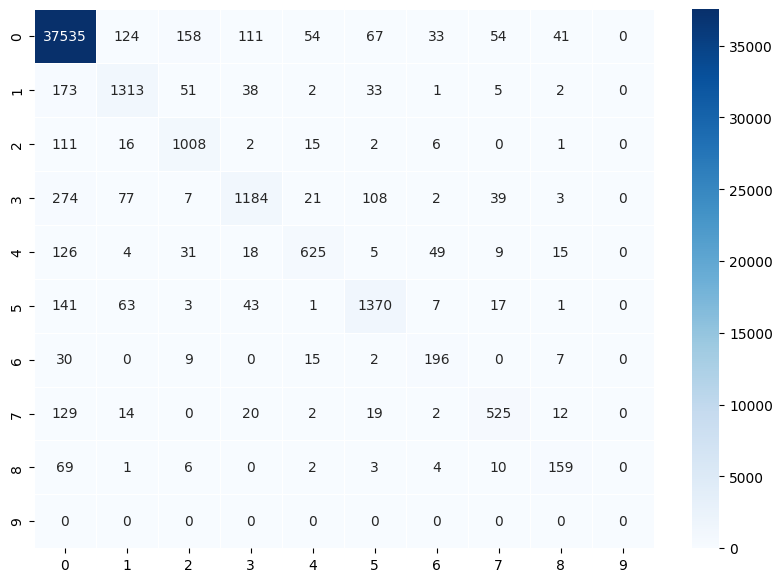

In [89]:
# test on the last model
trainer.test(model,masked_consonants_testloader)

In [90]:
# test on the best model based on val loss
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='masked-consonants',),
    vocab_size=masked_consonants_tokenizer.vocab_size,
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(22233, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9459947943687439     │
│         test_loss         │    0.23862041532993317    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9459947943687439, 'test_loss': 0.23862041532993317}]

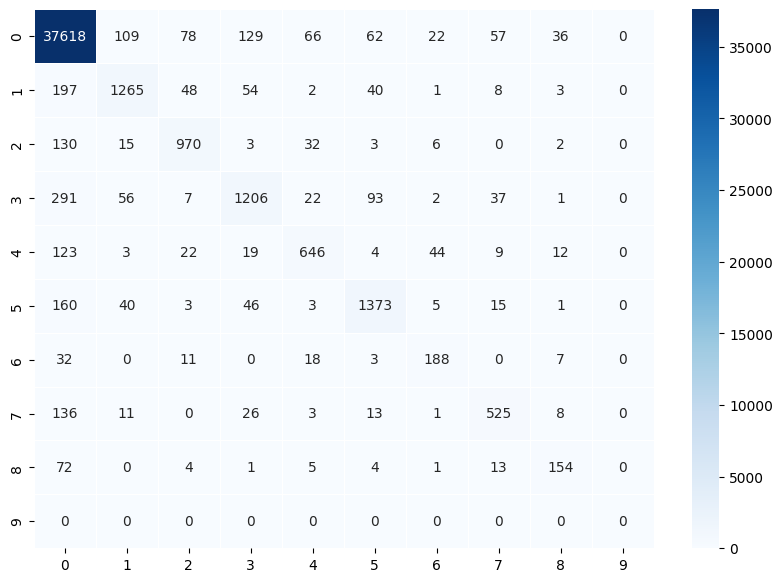

In [91]:
trainer.test(model,masked_consonants_testloader)

# Normal English without vowel words

## Prepare the dataset

In [92]:
train_dataset['tokens_without_vowel_words'] = train_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)
train_dataset

  0%|          | 0/14040 [00:00<?, ?it/s]

<ipython-input-92-a4cb804fc619>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['tokens_without_vowel_words'] = train_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)


id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  \
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                          constants_ners  \
0                               [0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                        constants_tokens  \
0            [rjcts, Grmn, cll, t, byctt, Brtsh, lmb, .]   
1                                         [Ptr, Blckbrn]   
2                                   [BRSSLS, 1996-08-22]   
3      [Th, rpn, Cmmssn, sd, n, Thrsdy, t, dsgrd, wth...   
4      [Grmny, 's, rp

In [93]:
validation_dataset['tokens_without_vowel_words'] = validation_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)
validation_dataset

  0%|          | 0/3250 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...   
1        1                               [LONDON, 1996-08-30]   
2        2  [West, Indian, all-rounder, Phil, Simmons, too...   
3        3  [Their, stay, on, top, ,, though, ,, may, be, ...   
4        4  [After, bowling, Somerset, out, for, 83, on, t...   
...    ...                                                ...   
3245  3245  [But, the, prices, may, move, in, a, close, ra...   
3246  3246  [Brokers, said, blue, chips, like, IDLC, ,, Ba...   
3247  3247  [They, said, there, was, still, demand, for, b...   
3248  3248  [The, DSE, all, share, price, index, closed, 2...   
3249  3249                [--, Dhaka, Newsroom, 880-2-506363]   

                                               pos_tags  \
0            [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]   
1                                              [22, 11]   
2     [22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...   
3     [29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...   
4     [15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...   
...                                                 ...   
3245  [10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...   
3246  [24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...   
3247  [28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...   
3248  [12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...   
3249                                    [8, 22, 22, 11]   

                                             chunk_tags  \
0            [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]   
1                                              [11, 12]   
2     [11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...   
3     [11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...   
4     [13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...   
...                                                 ...   
3245  [0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...   
3246  [11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...   
3247  [11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...   
3248  [11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...   
3249                                    [0, 11, 12, 12]   

                                               ner_tags  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                         constants_ners  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                       constants_tokens  \
0     [CRCKT, -, LCSTRSHR, TK, VR, T, TP, FTR, NNNGS...   
1                                    [LNDN, 1996-08-30]   
2     [Wst, ndn, ll-rndr, Phl, Smmns, tk, fr, fr, 38...   
3     [Thr, sty, n, tp, ,, thgh, ,, my, b, shrt-lvd,...   
4     [ftr, bwlng, Smrst, t, fr, 83, n, th, pnng, mr...   
...                                  

In [94]:
test_dataset['tokens_without_vowel_words'] = test_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)
test_dataset

  0%|          | 0/3453 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...   
1        1                                     [Nadim, Ladki]   
2        2    [AL-AIN, ,, United, Arab, Emirates, 1996-12-06]   
3        3  [Japan, began, the, defence, of, their, Asian,...   
4        4  [But, China, saw, their, luck, desert, them, i...   
...    ...                                                ...   
3448  3448  [That, is, why, this, is, so, emotional, a, ni...   
3449  3449  [", It, was, the, joy, that, we, all, had, ove...   
3450  3450  [Charlton, managed, Ireland, for, 93, matches,...   
3451  3451  [He, guided, Ireland, to, two, successive, Wor...   
3452  3452  [The, lanky, former, Leeds, United, defender, ...   

                                               pos_tags  \
0         [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7]   
1                                              [22, 22]   
2                               [22, 6, 22, 22, 23, 11]   
3     [22, 38, 12, 21, 15, 29, 16, 22, 21, 15, 12, 1...   
4     [10, 22, 38, 29, 21, 37, 28, 15, 12, 21, 21, 1...   
...                                                 ...   
3448  [12, 42, 46, 12, 42, 30, 16, 12, 21, 15, 28, 6...   
3449  [0, 28, 38, 12, 21, 15, 28, 12, 38, 15, 12, 21...   
3450  [22, 38, 22, 15, 11, 24, 6, 15, 43, 21, 28, 38...   
3451  [28, 38, 22, 35, 11, 16, 22, 22, 24, 24, 10, 3...   
3452  [12, 16, 16, 22, 22, 21, 38, 30, 37, 29, 22, 2...   

                                             chunk_tags  \
0         [12, 0, 12, 22, 12, 12, 0, 12, 14, 12, 12, 0]   
1                                              [12, 12]   
2                               [12, 0, 12, 12, 12, 12]   
3     [12, 22, 12, 12, 14, 12, 12, 12, 12, 14, 12, 1...   
4     [0, 12, 22, 12, 12, 22, 12, 14, 12, 12, 12, 14...   
...                                                 ...   
3448  [12, 22, 4, 12, 22, 2, 2, 12, 12, 14, 12, 0, 0...   
3449  [0, 12, 22, 12, 12, 18, 12, 11, 22, 14, 12, 12...   
3450  [12, 22, 12, 14, 12, 12, 0, 14, 12, 12, 11, 22...   
3451  [12, 22, 12, 22, 12, 12, 12, 12, 12, 12, 0, 14...   
3452  [12, 12, 12, 12, 12, 12, 22, 22, 22, 12, 12, 1...   

                                               ner_tags  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                         constants_ners  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 5, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                       constants_tokens  \
0     [SCCR, -, JPN, GT, LCKY, WN, ,, CHN, N, SRPRS,...   
1                                            [Ndm, Ldk]   
2                   [L-N, ,, ntd, rb, mrts, 1996-12-06]   
3     [Jpn, bgn, th, dfnc, f, thr, sn, Cp, ttl, wth,...   
4     [Bt, Chn, sw, thr, lck, dsrt, thm, n, th, scnd...   
...                                  

## Prepare the tokenizer

In [95]:
tokenizer_without_vowel_words = tk.WordTokenizer(vocab_size=1_000_000)

In [96]:
tokenizer_without_vowel_words.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['tokens_without_vowel_words']))

Training WordTokenizer ...


In [97]:
tokenizer_without_vowel_words.vocab_size

23605

In [98]:
# test the tokenizer
tokenizer_without_vowel_words.tokenize('the hello is a good world , fractionally')

['the', '<UNK>', 'is', '<UNK>', 'good', 'world', ',', 'fractionally']

## tokenize and split

In [99]:
encoded_trainset_without_vowel_words,trainy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=train_dataset['tokens_without_vowel_words'],
    tags_list=train_dataset['constants_ners'],
    tokenizer=tokenizer_without_vowel_words,
  )
encoded_valset_without_vowel_words,valy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=validation_dataset['tokens_without_vowel_words'],
    tags_list=validation_dataset['constants_ners'],
    tokenizer=tokenizer_without_vowel_words,
  )
encoded_testset_without_vowel_words,testy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=test_dataset['tokens_without_vowel_words'],
    tags_list=test_dataset['constants_ners'],
    tokenizer=tokenizer_without_vowel_words,
  )
encoded_trainset_without_vowel_words.shape,trainy_without_vowel_words.shape,\
encoded_valset_without_vowel_words.shape,valy_without_vowel_words.shape,\
encoded_testset_without_vowel_words.shape,testy_without_vowel_words.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((14040, 130),
 (14040, 130),
 (3250, 130),
 (3250, 130),
 (3453, 130),
 (3453, 130))

In [100]:
# create tensor datasets
trainset_without_vowel_words = TensorDataset(torch.from_numpy(encoded_trainset_without_vowel_words), torch.from_numpy(trainy_without_vowel_words))
validset_without_vowel_words = TensorDataset(torch.from_numpy(encoded_valset_without_vowel_words), torch.from_numpy(valy_without_vowel_words))
testset_without_vowel_words = TensorDataset(torch.from_numpy(encoded_testset_without_vowel_words), torch.from_numpy(testy_without_vowel_words))

In [101]:
# create dataloaders
trainloader_without_vowel_words = DataLoader(trainset_without_vowel_words, shuffle=True, batch_size=batch_size,num_workers=4)
valloader_without_vowel_words = DataLoader(validset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)
testloader_without_vowel_words = DataLoader(testset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [102]:
model = LitBiLSTMModel(vocab_size=tokenizer_without_vowel_words.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(23605, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [103]:
trainer = train_model(
    model,
    train_dataloader=trainloader_without_vowel_words,
    val_dataloader=valloader_without_vowel_words,
    text_type='all-characters-without-vowel-words',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.270878314971924     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 12.1 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 2.6 K 
---------------------------------------------------------
18.4 M    Trainable params
0         Non-trainable params
18.4 M    Total params
73.585    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9507848620414734     │
│         test_loss         │    0.22088338434696198    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9507848620414734, 'test_loss': 0.22088338434696198}]

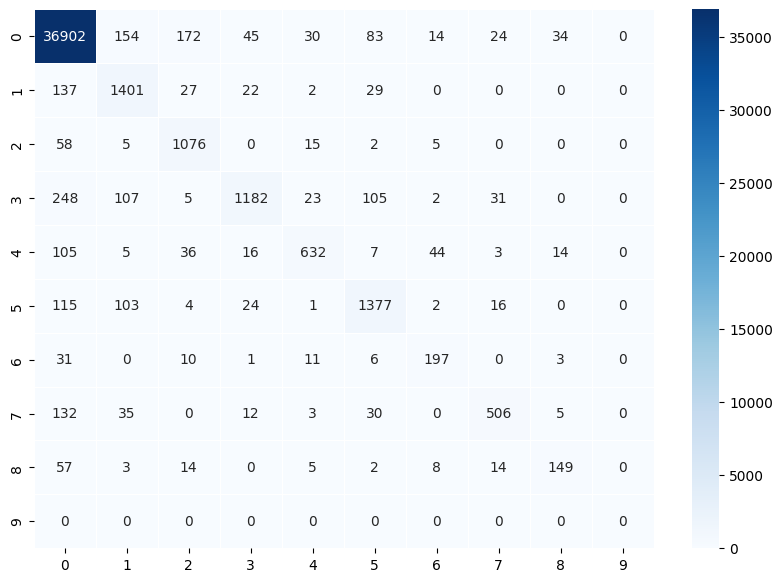

In [104]:
# test on the last model
trainer.test(model,testloader_without_vowel_words)

In [105]:
# test on teh best model according to val accuracy
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters-without-vowel-words',),
    vocab_size=tokenizer_without_vowel_words.vocab_size
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(23605, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9497998952865601     │
│         test_loss         │    0.2086014449596405     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9497998952865601, 'test_loss': 0.2086014449596405}]

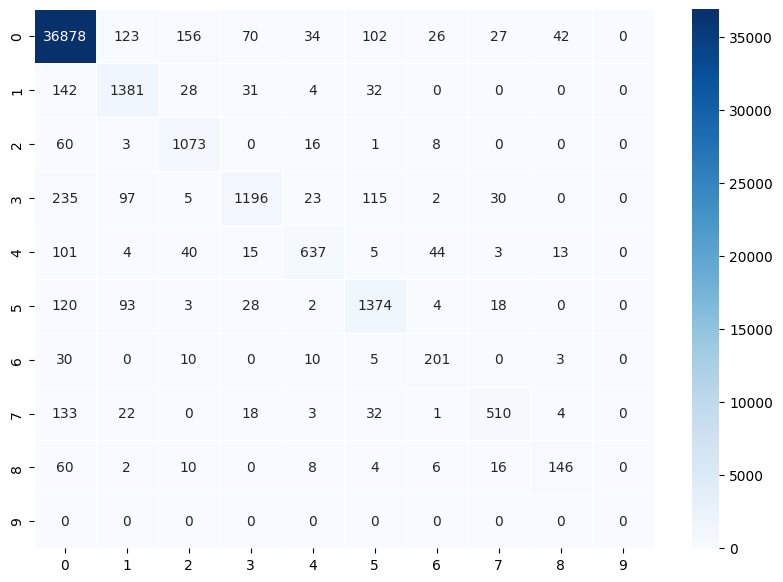

In [106]:
trainer.test(model,testloader_without_vowel_words)

# Masked Consontants without vowel words

## Prepare the dataset

In [107]:
train_dataset['masked_tokens_without_vowel_words'] = train_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
train_dataset

  0%|          | 0/14040 [00:00<?, ?it/s]

<ipython-input-107-ac6e32bd0a6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['masked_tokens_without_vowel_words'] = train_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))


id                                             tokens  \
0          0  [EU, rejects, German, call, to, boycott, Briti...   
1          1                                 [Peter, Blackburn]   
2          2                             [BRUSSELS, 1996-08-22]   
3          3  [The, European, Commission, said, on, Thursday...   
4          4  [Germany, 's, representative, to, the, Europea...   
...      ...                                                ...   
14036  14036                                    [on, Friday, :]   
14037  14037                                    [Division, two]   
14038  14038                          [Plymouth, 2, Preston, 1]   
14039  14039                                  [Division, three]   
14040  14040                           [Swansea, 1, Lincoln, 2]   

                                                pos_tags  \
0                    [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                               [22, 22]   
2                                               [22, 11]   
3      [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4      [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   
...                                                  ...   
14036                                        [15, 22, 8]   
14037                                           [21, 11]   
14038                                   [21, 11, 22, 11]   
14039                                           [21, 11]   
14040                                   [21, 11, 22, 11]   

                                              chunk_tags  \
0                    [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                               [11, 12]   
2                                               [11, 12]   
3      [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4      [11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...   
...                                                  ...   
14036                                        [13, 11, 0]   
14037                                           [11, 12]   
14038                                   [11, 12, 12, 12]   
14039                                           [11, 12]   
14040                                   [11, 12, 12, 12]   

                                                ner_tags  \
0                            [3, 0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                          constants_ners  \
0                               [0, 7, 0, 0, 0, 7, 0, 0]   
1                                                 [1, 2]   
2                                                 [5, 0]   
3      [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ...   
4      [5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ...   
...                                                  ...   
14036                                          [0, 0, 0]   
14037                                             [0, 0]   
14038                                       [3, 0, 3, 0]   
14039                                             [0, 0]   
14040                                       [3, 0, 3, 0]   

                                        constants_tokens  \
0            [rjcts, Grmn, cll, t, byctt, Brtsh, lmb, .]   
1                                         [Ptr, Blckbrn]   
2                                   [BRSSLS, 1996-08-22]   
3      [Th, rpn, Cmmssn, sd, n, Thrsdy, t, dsgrd, wth...   
4      [Grmny, 's, rp

In [108]:
validation_dataset['masked_tokens_without_vowel_words'] = validation_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
validation_dataset

  0%|          | 0/3250 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, T...   
1        1                               [LONDON, 1996-08-30]   
2        2  [West, Indian, all-rounder, Phil, Simmons, too...   
3        3  [Their, stay, on, top, ,, though, ,, may, be, ...   
4        4  [After, bowling, Somerset, out, for, 83, on, t...   
...    ...                                                ...   
3245  3245  [But, the, prices, may, move, in, a, close, ra...   
3246  3246  [Brokers, said, blue, chips, like, IDLC, ,, Ba...   
3247  3247  [They, said, there, was, still, demand, for, b...   
3248  3248  [The, DSE, all, share, price, index, closed, 2...   
3249  3249                [--, Dhaka, Newsroom, 880-2-506363]   

                                               pos_tags  \
0            [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7]   
1                                              [22, 11]   
2     [22, 22, 21, 22, 22, 38, 11, 15, 11, 15, 22, 1...   
3     [29, 21, 15, 21, 6, 30, 6, 20, 37, 16, 15, 21,...   
4     [15, 39, 22, 33, 15, 11, 15, 12, 21, 21, 15, 2...   
...                                                 ...   
3245  [10, 12, 24, 20, 37, 15, 12, 16, 21, 39, 12, 4...   
3246  [24, 38, 16, 24, 15, 22, 6, 22, 22, 6, 22, 22,...   
3247  [28, 38, 13, 38, 30, 37, 15, 16, 24, 15, 21, 2...   
3248  [12, 21, 12, 21, 21, 21, 38, 11, 24, 10, 11, 2...   
3249                                    [8, 22, 22, 11]   

                                             chunk_tags  \
0            [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0]   
1                                              [11, 12]   
2     [11, 12, 12, 12, 12, 21, 11, 13, 11, 13, 11, 1...   
3     [11, 12, 13, 11, 0, 3, 0, 21, 22, 1, 13, 11, 1...   
4     [13, 11, 12, 15, 13, 11, 13, 11, 12, 12, 13, 1...   
...                                                 ...   
3245  [0, 11, 12, 21, 22, 13, 11, 12, 12, 13, 11, 12...   
3246  [11, 21, 11, 12, 13, 11, 0, 11, 12, 0, 11, 12,...   
3247  [11, 21, 11, 21, 22, 22, 13, 11, 12, 13, 11, 1...   
3248  [11, 12, 11, 12, 12, 12, 21, 11, 12, 0, 11, 12...   
3249                                    [0, 11, 12, 12]   

                                               ner_tags  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                         constants_ners  \
0                     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]   
1                                                [5, 0]   
2     [7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...   
4     [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 3, ...   
...                                                 ...   
3245         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3246  [0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, ...   
3247  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3248  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3249                                       [0, 3, 4, 0]   

                                       constants_tokens  \
0     [CRCKT, -, LCSTRSHR, TK, VR, T, TP, FTR, NNNGS...   
1                                    [LNDN, 1996-08-30]   
2     [Wst, ndn, ll-rndr, Phl, Smmns, tk, fr, fr, 38...   
3     [Thr, sty, n, tp, ,, thgh, ,, my, b, shrt-lvd,...   
4     [ftr, bwlng, Smrst, t, fr, 83, n, th, pnng, mr...   
...                                  

In [109]:
test_dataset['masked_tokens_without_vowel_words'] = test_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
test_dataset

  0%|          | 0/3453 [00:00<?, ?it/s]

id                                             tokens  \
0        0  [SOCCER, -, JAPAN, GET, LUCKY, WIN, ,, CHINA, ...   
1        1                                     [Nadim, Ladki]   
2        2    [AL-AIN, ,, United, Arab, Emirates, 1996-12-06]   
3        3  [Japan, began, the, defence, of, their, Asian,...   
4        4  [But, China, saw, their, luck, desert, them, i...   
...    ...                                                ...   
3448  3448  [That, is, why, this, is, so, emotional, a, ni...   
3449  3449  [", It, was, the, joy, that, we, all, had, ove...   
3450  3450  [Charlton, managed, Ireland, for, 93, matches,...   
3451  3451  [He, guided, Ireland, to, two, successive, Wor...   
3452  3452  [The, lanky, former, Leeds, United, defender, ...   

                                               pos_tags  \
0         [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7]   
1                                              [22, 22]   
2                               [22, 6, 22, 22, 23, 11]   
3     [22, 38, 12, 21, 15, 29, 16, 22, 21, 15, 12, 1...   
4     [10, 22, 38, 29, 21, 37, 28, 15, 12, 21, 21, 1...   
...                                                 ...   
3448  [12, 42, 46, 12, 42, 30, 16, 12, 21, 15, 28, 6...   
3449  [0, 28, 38, 12, 21, 15, 28, 12, 38, 15, 12, 21...   
3450  [22, 38, 22, 15, 11, 24, 6, 15, 43, 21, 28, 38...   
3451  [28, 38, 22, 35, 11, 16, 22, 22, 24, 24, 10, 3...   
3452  [12, 16, 16, 22, 22, 21, 38, 30, 37, 29, 22, 2...   

                                             chunk_tags  \
0         [12, 0, 12, 22, 12, 12, 0, 12, 14, 12, 12, 0]   
1                                              [12, 12]   
2                               [12, 0, 12, 12, 12, 12]   
3     [12, 22, 12, 12, 14, 12, 12, 12, 12, 14, 12, 1...   
4     [0, 12, 22, 12, 12, 22, 12, 14, 12, 12, 12, 14...   
...                                                 ...   
3448  [12, 22, 4, 12, 22, 2, 2, 12, 12, 14, 12, 0, 0...   
3449  [0, 12, 22, 12, 12, 18, 12, 11, 22, 14, 12, 12...   
3450  [12, 22, 12, 14, 12, 12, 0, 14, 12, 12, 11, 22...   
3451  [12, 22, 12, 22, 12, 12, 12, 12, 12, 12, 0, 14...   
3452  [12, 12, 12, 12, 12, 12, 22, 22, 22, 12, 12, 1...   

                                               ner_tags  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                         constants_ners  \
0                  [0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]   
1                                                [1, 2]   
2                                    [5, 0, 5, 6, 6, 0]   
3     [5, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 5, ...   
4     [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
3448      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
3449  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3450  [1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3451  [0, 0, 5, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 7, ...   
3452  [0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ...   

                                       constants_tokens  \
0     [SCCR, -, JPN, GT, LCKY, WN, ,, CHN, N, SRPRS,...   
1                                            [Ndm, Ldk]   
2                   [L-N, ,, ntd, rb, mrts, 1996-12-06]   
3     [Jpn, bgn, th, dfnc, f, thr, sn, Cp, ttl, wth,...   
4     [Bt, Chn, sw, thr, lck, dsrt, thm, n, th, scnd...   
...                                  

## Prepare the tokenizer

In [110]:
masked_tokenizer_without_vowel_words = tk.WordTokenizer(vocab_size=1_000_000)

In [111]:
masked_tokenizer_without_vowel_words.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['masked_tokens_without_vowel_words']))

Training WordTokenizer ...


In [112]:
masked_tokenizer_without_vowel_words.vocab_size

22230

In [113]:
# test the tokenizer
masked_tokenizer_without_vowel_words.tokenize('tha halla as a gaad warld , fractaanally')

['tha', '<UNK>', 'as', '<UNK>', 'gaad', 'warld', ',', 'fractaanally']

## tokenize and split

In [114]:
masked_encoded_trainset_without_vowel_words,masked_trainy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=train_dataset['masked_tokens_without_vowel_words'],
    tags_list=train_dataset['constants_ners'],
    tokenizer=masked_tokenizer_without_vowel_words,
  )
masked_encoded_valset_without_vowel_words,masked_valy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=validation_dataset['masked_tokens_without_vowel_words'],
    tags_list=validation_dataset['constants_ners'],
    tokenizer=masked_tokenizer_without_vowel_words,
  )
masked_encoded_testset_without_vowel_words,masked_testy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=test_dataset['masked_tokens_without_vowel_words'],
    tags_list=test_dataset['constants_ners'],
    tokenizer=masked_tokenizer_without_vowel_words,
  )
masked_encoded_trainset_without_vowel_words.shape,masked_trainy_without_vowel_words.shape,\
masked_encoded_valset_without_vowel_words.shape,masked_valy_without_vowel_words.shape,\
masked_encoded_testset_without_vowel_words.shape,masked_testy_without_vowel_words.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((14040, 130),
 (14040, 130),
 (3250, 130),
 (3250, 130),
 (3453, 130),
 (3453, 130))

In [115]:
# create tensor datasets
masked_trainset_without_vowel_words = TensorDataset(torch.from_numpy(masked_encoded_trainset_without_vowel_words), torch.from_numpy(masked_trainy_without_vowel_words))
masked_validset_without_vowel_words = TensorDataset(torch.from_numpy(masked_encoded_valset_without_vowel_words), torch.from_numpy(masked_valy_without_vowel_words))
masked_testset_without_vowel_words = TensorDataset(torch.from_numpy(masked_encoded_testset_without_vowel_words), torch.from_numpy(masked_testy_without_vowel_words))

In [116]:
# create dataloaders
masked_trainloader_without_vowel_words = DataLoader(masked_trainset_without_vowel_words, shuffle=True, batch_size=batch_size,num_workers=4)
masked_valloader_without_vowel_words = DataLoader(masked_validset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)
masked_testloader_without_vowel_words = DataLoader(masked_testset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [117]:
model = LitBiLSTMModel(vocab_size=masked_tokenizer_without_vowel_words.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(22230, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [118]:
trainer = train_model(
    model,
    train_dataloader=masked_trainloader_without_vowel_words,
    val_dataloader=masked_valloader_without_vowel_words,
    text_type='masked-consonants-without-vowel-words',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.324526071548462     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 11.4 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 2.6 K 
---------------------------------------------------------
17.7 M    Trainable params
0         Non-trainable params
17.7 M    Total params
70.769    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9474743604660034     │
│         test_loss         │    0.2206335812807083     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9474743604660034, 'test_loss': 0.2206335812807083}]

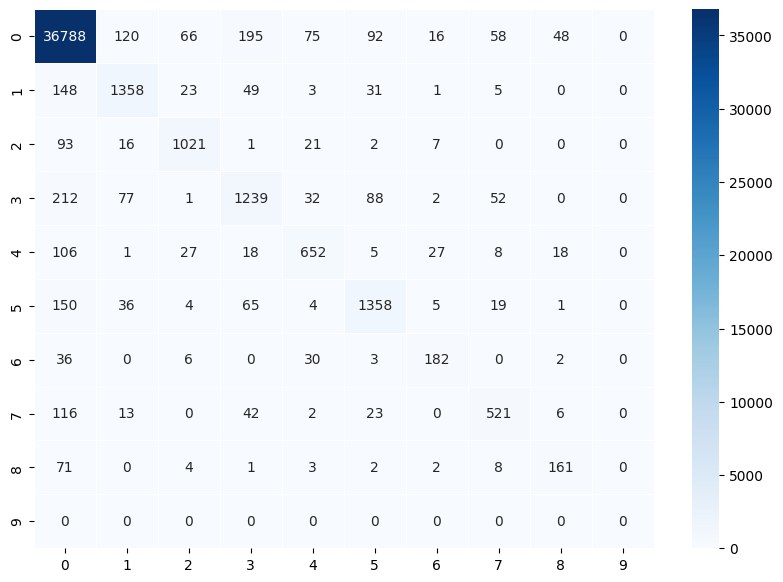

In [119]:
# test on the last model
trainer.test(model,masked_testloader_without_vowel_words)

In [120]:
# test on teh best model according to val accuracy
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='masked-consonants-without-vowel-words',),
    vocab_size=masked_tokenizer_without_vowel_words.vocab_size
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(22230, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9469907283782959     │
│         test_loss         │    0.21578335762023926    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9469907283782959, 'test_loss': 0.21578335762023926}]

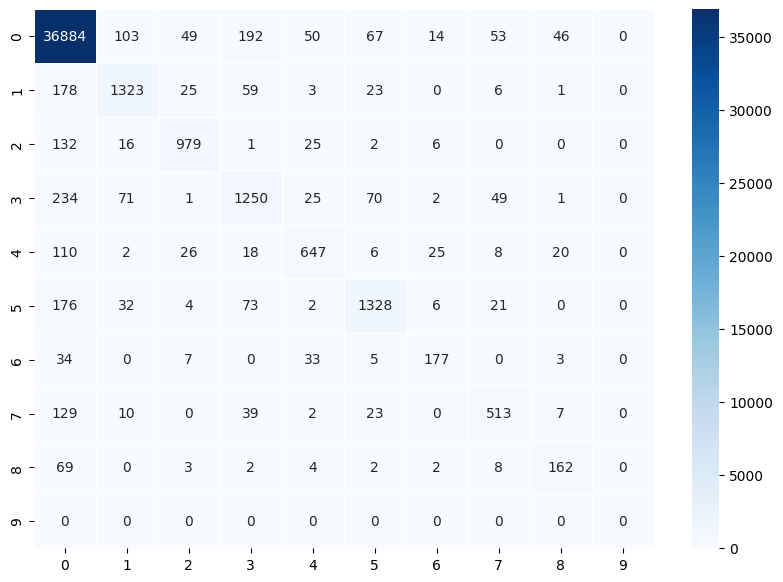

In [121]:
trainer.test(model,masked_testloader_without_vowel_words)